#### Importing Libraries

In [113]:
# Data handling
import pandas as pd
import numpy as np
import string

# Train-test split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Baseline model
from sklearn.naive_bayes import MultinomialNB

# Model evaluation
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import os
import sys

import nltk
# Download necessary NLTK data
# nltk.download('stopwords', quiet=True)
# nltk.download('punkt', quiet=True)

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- PATH SETUP ---
curr_dir = os.getcwd()
parent_dir = os.path.dirname(curr_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Data_Processing.EDA import DataProcessor
# from Models.TF_IDF_Model import TFIDFModel

#### Load Data

In [114]:
data_processor = DataProcessor(data_path="../data/raw/SMSSpamCollection")
data_processor.load_data(sep="\t", names=['label', 'message'])

df = data_processor.data
print(df)

Data loaded successfully.
     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


#### Explore the data distribution


--- Data Distribution ---
label
ham     4825
spam     747
Name: count, dtype: int64

--- Class Percentage ---
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


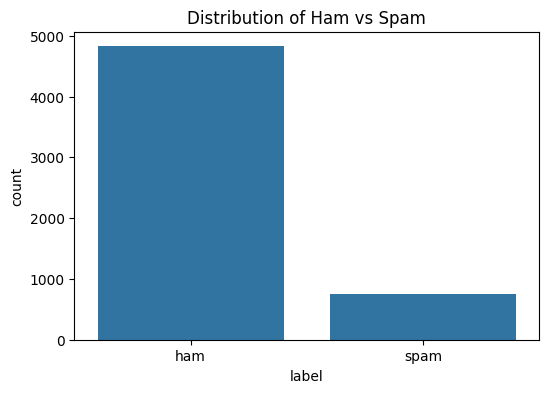

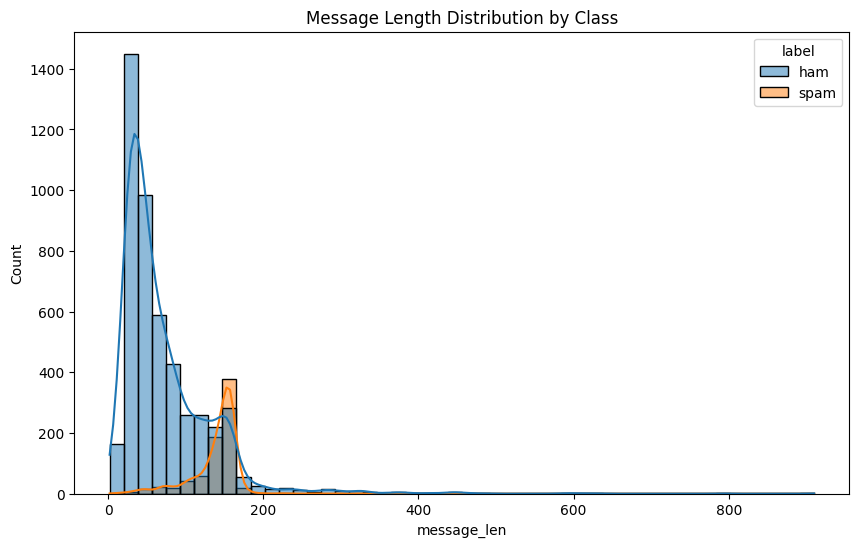

In [115]:
print("\n--- Data Distribution ---")
print(df['label'].value_counts())

print("\n--- Class Percentage ---")
print(df['label'].value_counts(normalize=True) * 100)

# Visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Ham vs Spam')
plt.show()

# Add a feature for 'message length' to see if it varies by class
df['message_len'] = df['message'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_len', hue='label', bins=50, kde=True)
plt.title('Message Length Distribution by Class')
plt.show()

In [116]:
# Delete 3572 rows of ham messages to make the dataset less imbalanced
ham_indices = df[df['label'] == 'ham'].index
df = df.drop(ham_indices[:3572])  # Drop first 3572 ham messages
print("\n--- Data Distribution After Balancing ---")
print(df['label'].value_counts())
print("Total messages after balancing:", len(df))


--- Data Distribution After Balancing ---
label
ham     1253
spam     747
Name: count, dtype: int64
Total messages after balancing: 2000


#### Apply text preprocessing

In [117]:


print("\n--- Applying Text Preprocessing... ---")
# Apply the cleaning function to the message column
df['clean_message'] = df['message'].apply(data_processor.preprocess_text)

print("Preprocessing complete. Comparison:")
df.head()



--- Applying Text Preprocessing... ---
Preprocessing complete. Comparison:


,label,message,message_len,clean_message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,freemsg hey darling 3 weeks word back id like ...
8,spam,WINNER!! As a valued network customer you have...,157,winner valued network customer selected receiv...
9,spam,Had your mobile 11 months or more? U R entitle...,154,mobile 11 months u r entitled update latest co...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,six chances win cash 100 20000 pounds txt csh1...


#### Split into training and test sets (75% - 25%)

In [118]:
# X contains the features (messages) 
# y contains the target (labels)
X = df['clean_message']
y = df['label']

# random_state ensures reproducibility
# stratify=y ensures the ratio of spam/ham is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("\n--- Split Summary ---")
print(f"Total samples: {len(df)}")
print(f"Training set size: {len(X_train)} (approx 75%)")
print(f"Testing set size: {len(X_test)} (approx 25%)")


--- Split Summary ---
Total samples: 2000
Training set size: 1500 (approx 75%)
Testing set size: 500 (approx 25%)


#### Convert text documents into numerical TF-IDF features

In [119]:
# We limit max_features to 1000 to keep the matrix manageable for visualization.
# min_df=5 ignores terms that appear in fewer than 5 documents.
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=1000)

# Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Only transform the test data (do not re-fit)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Vectorization Complete.")
print(f"Training Matrix Shape: {X_train_tfidf.shape}")
print(f"Testing Matrix Shape: {X_test_tfidf.shape}")



TF-IDF Vectorization Complete.
Training Matrix Shape: (1500, 675)
Testing Matrix Shape: (500, 675)


#### Understand how TF-IDF weights terms by importance

In [120]:
# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame of IDF weights
idf_df = pd.DataFrame({
    'term': feature_names,
    'idf_weight': tfidf_vectorizer.idf_
})

# Sort by IDF weight to see the most common vs. rarest words
# Lower IDF = More frequent (less unique information, e.g., "to", "you")
# Higher IDF = Rare (more unique information, e.g., specific codes or names)
print("\n--- Top 5 Most Frequent Words (Lowest IDF) ---")
print(idf_df.sort_values(by='idf_weight').head(5))

print("\n--- Top 5 Rarest Words (Highest IDF) ---")
print(idf_df.sort_values(by='idf_weight', ascending=False).head(5))

# View the TF-IDF matrix (as a dense table)
print("\nTF-IDF Matrix:\n", X_train_tfidf.toarray())

# Compute pairwise cosine similarities
similarities = cosine_similarity(X_train_tfidf)

# Show results
print("\nCosine Similarity Matrix:\n", similarities)


--- Top 5 Most Frequent Words (Lowest IDF) ---
     term  idf_weight
111  call    2.668440
237  free    3.372244
609    ur    3.509866
600   txt    3.650448
250   get    3.659926

--- Top 5 Rarest Words (Highest IDF) ---
            term  idf_weight
3           0870    6.522127
4    08707509020    6.522127
656        world    6.522127
654        words    6.522127
5    08712300220    6.522127

TF-IDF Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Cosine Similarity Matrix:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


#### Examine the vocabulary size and sample features

In [121]:
print(f"\nVocabulary Size: {len(feature_names)}")
print(f"Sample Features (first 10): {feature_names[:10]}")


Vocabulary Size: 675
Sample Features (first 10): ['0800' '08000839402' '08000930705' '0870' '08707509020' '08712300220'
 '08712460324' '09050090044' '10' '100']


#### Visualize the TF-IDF matrix structure

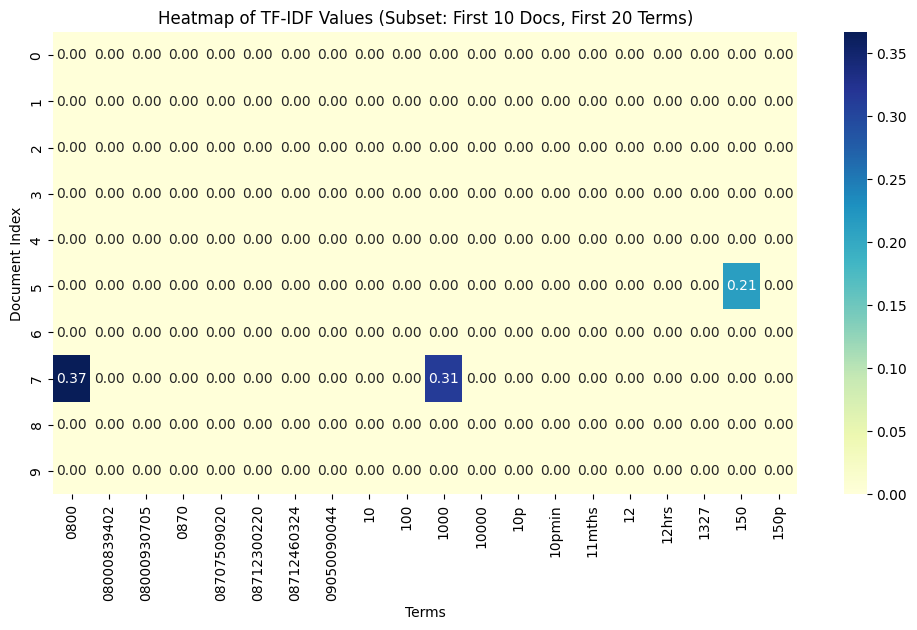

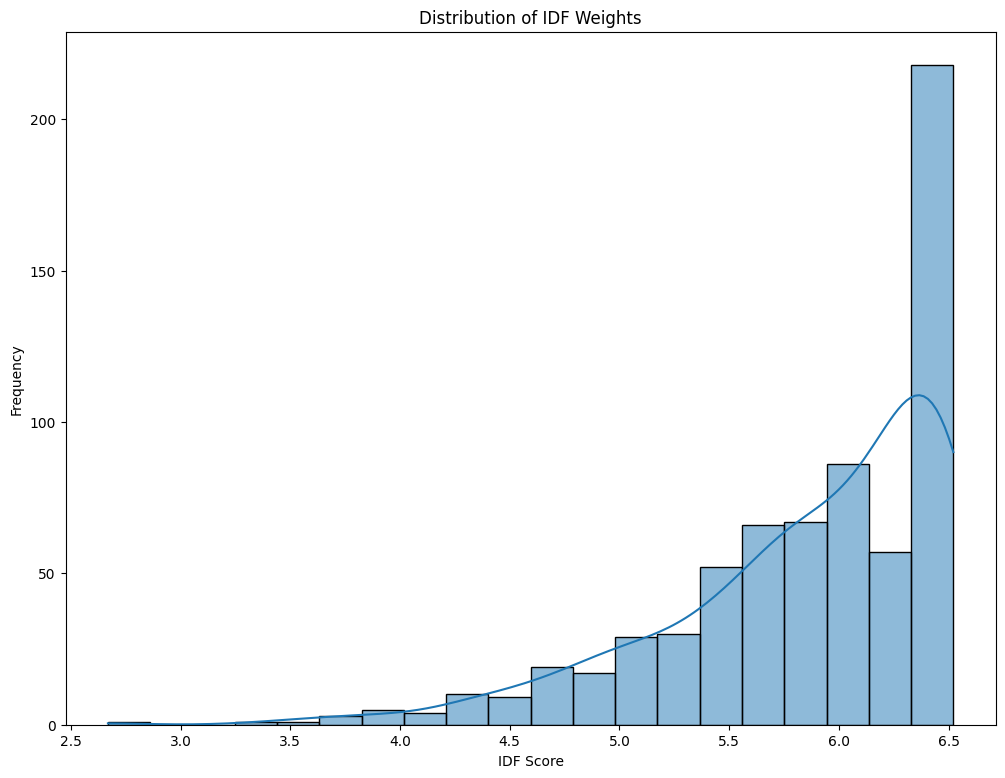

In [ ]:
# visualize a small subset (first 10 documents and first 20 terms) because the full matrix is too large and sparse.
subset_matrix = X_train_tfidf[:10, :20].toarray()
subset_df = pd.DataFrame(subset_matrix, columns=feature_names[:20])

plt.figure(figsize=(12, 6))
sns.heatmap(subset_df, annot=True, cmap='YlGnBu', cbar=True, fmt='.2f')
plt.title('Heatmap of TF-IDF Values (Subset: First 10 Docs, First 20 Terms)')
plt.xlabel('Terms')
plt.ylabel('Document Index')
plt.savefig('../data/output_plots/tfidf_heatmap.png') # Saving for reference
plt.show()

# Visualize the distribution of IDF weights
plt.figure(figsize=(11, 8))
sns.histplot(idf_df['idf_weight'], bins=20, kde=True)
plt.title('Distribution of IDF Weights')
plt.xlabel('IDF Score')
plt.ylabel('Frequency')
plt.savefig('../data/output_plots/idf_distribution.png')
plt.show()

#### Baseline Model - Naive Bayes with TF-IDF

In [123]:
# Train a Naive Bayes classifier
# Naive Bayes is suitable for classification with discrete features (e.g., word counts or TF-IDF weights)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
print("Naive Bayes Model Trained.")

Naive Bayes Model Trained.


#### Make predictions on the test set

In [124]:
y_pred = nb_classifier.predict(X_test_tfidf)

#### Create and visualize a confusion matrix

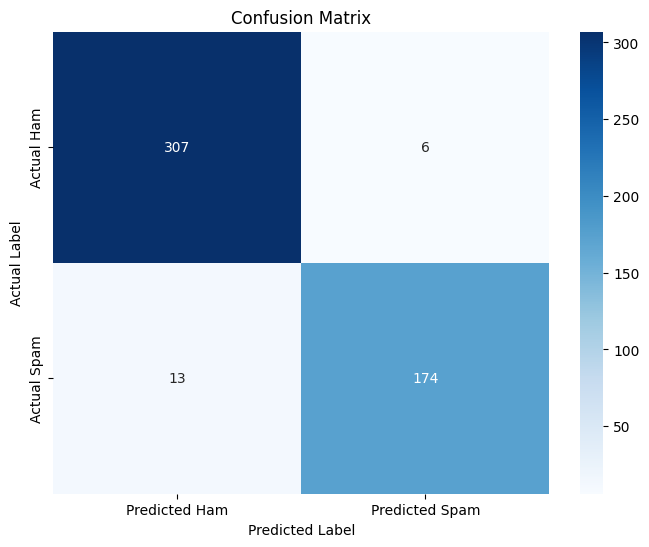

In [125]:
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Ham', 'Predicted Spam'], 
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('../data/output_plots/confusion_matrix.png')
plt.show()

#### Calculate metrics

In [126]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')
f1 = f1_score(y_test, y_pred, pos_label='spam')

print("\n--- Evaluation Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


--- Evaluation Metrics ---
Accuracy:  0.9620
Precision: 0.9667
Recall:    0.9305
F1-Score:  0.9482


#### Interpret the results

In [127]:
tn, fp, fn, tp = cm.ravel()
print("\n--- Interpretation ---")
print(f"True Negatives (TN): {tn} (Ham correctly identified as Ham)")
print(f"False Positives (FP): {fp} (Ham incorrectly identified as Spam)")
print(f"False Negatives (FN): {fn} (Spam incorrectly identified as Ham)")
print(f"True Positives (TP): {tp} (Spam correctly identified as Spam)")

print("\nError Analysis:")
print(f"- The model made {fp} False Positive error(s). This is very low, meaning it almost never flags a real message as spam.")
print(f"- The model made {fn} False Negative error(s). This is higher, meaning some spam messages are slipping through into the inbox.")

print("\nOverall:")
if precision > recall:
    print("The model is more precise than sensitive. It is very confident when it labels something as spam, but it misses some spam messages.")
else:
    print("The model is more sensitive than precise. It catches most spam messages, but sometimes mislabels real messages as spam.")


--- Interpretation ---
True Negatives (TN): 307 (Ham correctly identified as Ham)
False Positives (FP): 6 (Ham incorrectly identified as Spam)
False Negatives (FN): 13 (Spam incorrectly identified as Ham)
True Positives (TP): 174 (Spam correctly identified as Spam)

Error Analysis:
- The model made 6 False Positive error(s). This is very low, meaning it almost never flags a real message as spam.
- The model made 13 False Negative error(s). This is higher, meaning some spam messages are slipping through into the inbox.

Overall:
The model is more precise than sensitive. It is very confident when it labels something as spam, but it misses some spam messages.
